<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> ©2021 onwards</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>👂Phonemes</font>](https://www.kaggle.com/competitions/9sep24-phonemes/rules)**. [**Instructions**](https://colab.research.google.com/drive/1riOGrE_Fv-yfIbM5V4pgJx4DWcd92cZr#scrollTo=ITaPDPIQEgXV) for running Colabs.

<details>
  <summary><small>Sharing consent: <mark>[ X ]</mark></summary>
  <div>
We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is <b>optional</b> and this decision will not affect our grade in any way. <font color=gray><i>
Instructions: If ok with sharing your Colab for educational purposes, leave "X" in the check box.</i></font></small></div>

In [ ]:
# from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 3feb25-phonemes          # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                       # print public leaderboard

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
- competition is now set to: 3feb25-phonemes
Using competition: 3feb25-phonemes
  teamId  teamName                    submissionDate       score         
--------  --------------------------  -------------------  ------------  
13292417  10_Nainika_David_Casimir    2025-02-15 18:30:01  0.9386000000  
13314849  David Bishop190             2025-02-15 18:01:50  0.9386000000  
13322761  Richard Simmons             2025-02-15 15:16:54  0.9352000000  
13325074  Yang Zhang                  2025-02-15 02:29:37  0.9320000000  
13314265  ChipHenderson93             2025-02-15 16:41:10  0.9306000000  
13325558  SHUAI FANG                  2025-02-12 06:51:28  0.9304000000  
13322078  Kumar Narayanan             2025-02-15 07:13:42  0.9302000000  
13318791  Joshua Gompert              2025-02-15 05:54:26  0.9294000000  
13293344  Jenelle Millison            2025-02-14 01:49:00  0.9292000000  
13322753  Jung Woo James J

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, xgboost, lightgbm as lgb, librosa
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 2.41 s, sys: 363 ms, total: 2.77 s
Wall time: 3.22 s


In [ ]:
df = pd.read_csv('XY_Phonemes.csv', low_memory=False); df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID,g
0,11.14,15.17,19.12,18.78,13.79,18.98,20.09,19.16,17.32,19.76,...,7.79,10.95,10.05,8.67,10.84,9.50,7.96,9.04,0,NaN
1,10.84,15.20,19.80,17.82,14.10,17.93,19.54,20.97,16.65,22.41,...,12.95,13.05,11.95,11.07,10.81,9.71,11.57,12.22,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59998,12.15,15.78,21.27,19.61,15.14,21.44,23.24,20.91,17.42,21.22,...,8.82,8.00,7.44,8.32,6.51,8.33,6.83,7.02,436,ao
59999,14.78,14.08,15.70,15.51,15.36,15.52,14.68,15.57,15.48,15.45,...,12.87,13.26,13.16,12.65,13.90,13.10,11.16,13.53,436,sh


In [ ]:
df.info()   # observe datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 258 entries, x1 to g
dtypes: float64(256), int64(1), object(1)
memory usage: 118.1+ MB


In [ ]:
# Change string labels to numbers in order of increasing size of the entity (Star < Quasi Star < Galaxy)
# df.Class = df.Class.apply(lambda C: -1 if C=='S' else 0 if C=='Q' else 1 if C=='G' else None)

In [ ]:
vX = df.query('g!=g').drop('g', axis=1)  # slice a test sample (10K observations)
tXY = df.query('g==g')                   # slice training sample
tX, tY = tXY.drop('g', axis=1), tXY.g    # split into training I/O (60K-10K = 50K observation)

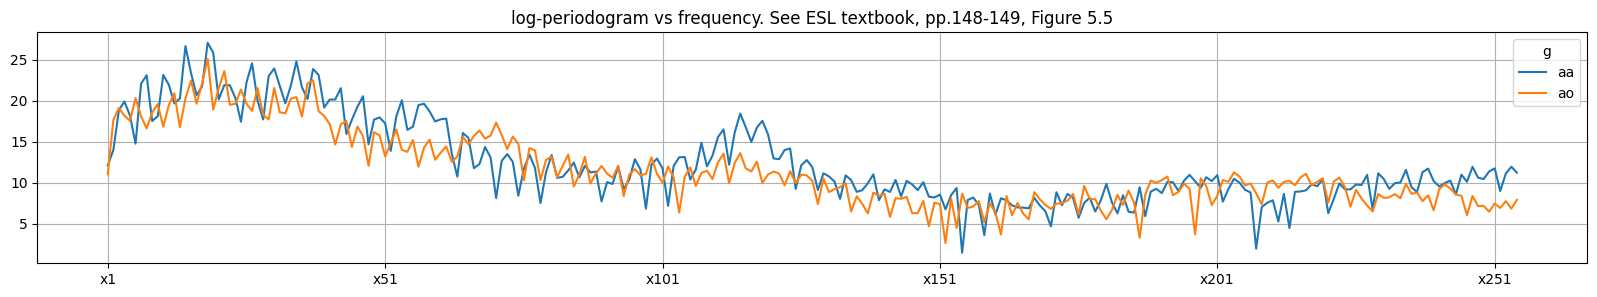

In [ ]:
aa = tXY[tXY.g=='aa'].set_index('g').iloc[[0],0:255]
ao = tXY[tXY.g=='ao'].set_index('g').iloc[[0],0:255]
_ = pd.concat([aa,ao]).T.plot(figsize=(20,3), grid=True, title='log-periodogram vs frequency. See ESL textbook, pp.148-149, Figure 5.5');

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

<font color=green><h3><b>Import Necessary Libraries</b><h3>


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

<font color=green><h3><b>Speaker-Based Scaling to Minimize Speaker-Related Differences in Data</b><h3>

In [ ]:
tX_speaker_id = tX['SpkrID'].copy()

def scale_per_speaker(df, speaker_column='SpkrID'):
    # Convert to NumPy for faster operations
    df_values = df.drop(columns=[speaker_column]).to_numpy()
    speaker_ids = df[speaker_column].to_numpy()

    # Unique speakers & pre-allocate array for scaled features
    unique_speakers = np.unique(speaker_ids)
    scaled_values = np.zeros_like(df_values)

    scaler = MinMaxScaler()

    # Scale each speaker subset efficiently
    for speaker in unique_speakers:
        speaker_mask = speaker_ids == speaker  # Boolean mask for this speaker
        scaled_values[speaker_mask] = scaler.fit_transform(df_values[speaker_mask])

    # Convert back to DataFrame
    df_scaled = pd.DataFrame(scaled_values, index=df.index, columns=df.columns.drop(speaker_column))

    return df_scaled

# Scale training set (tX) and test set (vX) separately
tX = scale_per_speaker(tX, speaker_column='SpkrID')
vX = scale_per_speaker(vX, speaker_column='SpkrID')

<font color=green><h3><b>Split Data into Training and Validation Datasets</b><h3>

In [ ]:
n = 1000
tX0, vX0, tY0, vY0 = train_test_split(tX, tY, test_size=n, stratify=tY, random_state=42)

tX0 = tX0.to_numpy()
#vX0 = vX0.to_numpy()
vX  = vX.to_numpy()

<font color=green><h3><b>Binning Every 4 Features for Reducing Feature Count</b><h3>

In [ ]:
num_bins = 64
bin_size = tX0.shape[1] // num_bins
tX0_binned = tX0.reshape(-1, num_bins, bin_size).mean(axis=2)
#vX0_binned = vX0.reshape(-1, num_bins, bin_size).mean(axis=2)
vX_binned  = vX.reshape(-1, num_bins, bin_size).mean(axis=2)

<font color=green><h3><b>Polynomial Feature Expansion (Degree = 2)</b><h3>

In [ ]:
poly = PolynomialFeatures(degree=2)

tX0_poly = poly.fit_transform(tX0_binned)
#vX0_poly = poly.transform(vX0_binned)
vX_poly  = poly.transform(vX_binned)

<font color=green><h3><b>Scaling Features</b><h3>

In [ ]:
scaler = StandardScaler()

tX0_scaled = scaler.fit_transform(tX0_poly)
#vX0_scaled = scaler.transform(vX0_poly)
vX_scaled  = scaler.transform(vX_poly)

<font color=green><h3><b>Principal Component Analyis for Dimensionality Reduction</b><h3>

<font color=green><h3><b>Retaining 97% Variance in Datatset</b><h3>

In [ ]:
#pca = PCA(n_components=0.97)  # Retain 97% of variance
#tX0_pca = pca.fit_transform(tX0_scaled)
#vX0_pca = pca.transform(vX0_scaled)
#vX_pca  = pca.transform(vX_scaled)

# IncrementalPCA to reduce runtime
# 42 components corresponds to 97% variance of the dataset
ipca = IncrementalPCA(n_components=42, batch_size=500)
tX0_pca = ipca.fit_transform(tX0_scaled)
vX_pca = ipca.transform(vX_scaled)

<font color=green><h3><b>Training Model - Linear Discriminant Analysis</b><h3>

In [ ]:
lda_main = LDA()
lda_main.fit(tX0_pca, tY0)

LinearDiscriminantAnalysis()

<font color=green><h3><b>Re-Predicting *aa* and *ao* Predictions</b><h3>

<font color=green><b>Training a new model on only the aa and ao data further focuses on distinguishing the two classes that are often misclassified as each other</b>

In [ ]:
# Isolate aa and ao data points from training set (post-binning)
aa_ao_train_mask = np.isin(tY0, ["aa", "ao"])
X_train_aa_ao = tX0_binned[aa_ao_train_mask]
y_train_aa_ao = tY0[aa_ao_train_mask]

# Scale the new subset of observations
scaler_aa_ao = StandardScaler()
X_train_aa_ao = scaler_aa_ao.fit_transform(X_train_aa_ao)

# Apply PCA - retaining 97% variance
pca_aa_ao = PCA(n_components=0.97)
X_train_aa_ao = pca_aa_ao.fit_transform(X_train_aa_ao)

#Train Second LDA Model
lda_aa_ao = LDA()
lda_aa_ao.fit(X_train_aa_ao, y_train_aa_ao)

LinearDiscriminantAnalysis()

<font color=green><h3><b>Prediction and Evaluation of the Validation Dataset</b><h3>

In [ ]:
# Predict primary classification on validation set
#y_pred_main = lda_main.predict(vX0_pca)

# Identify 'aa' vs 'ao' instances
#aa_ao_mask = np.isin(y_pred_main, ["aa", "ao"])
#X_val_aa_ao = vX0_binned[aa_ao_mask]
#y_val_aa_ao = y_pred_main[aa_ao_mask]

#X_val_aa_ao = scaler_aa_ao.transform(X_val_aa_ao)

# Apply PCA again to 'aa' vs 'ao' subset
#X_val_aa_ao = pca_aa_ao.transform(X_val_aa_ao)

# Reclassify 'aa' vs 'ao' using refined LDA
#if len(X_val_aa_ao) > 0:
#    y_pred_refined = lda_aa_ao.predict(X_val_aa_ao)
#    indices = np.where(aa_ao_mask)[0]
#    y_pred_main[indices] = y_pred_refined

#accuracy = accuracy_score(vY0, y_pred_main)
#print(f"\nClassification Accuracy: {accuracy:.4f}")

# Compute confusion matrix
#cm = confusion_matrix(vY0, y_pred_main, labels=np.unique(vY0))

# Plot confusion matrix
#plt.figure(figsize=(8,6))
#sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(vY0), yticklabels=np.unique(vY0))
#plt.xlabel("Predicted Label")
#plt.ylabel("True Label")
#plt.title("Confusion Matrix: Two-Model LDA with PCA Refinement for 'aa' vs 'ao'")

# Print classification report
#print("Classification Report on Validation Set:")
#print(classification_report(vY0, y_pred_main, target_names=np.unique(vY0)))

<font color=green><h3><b>Prediction of Test Dataset</b><h3>

In [ ]:
# Apply final predictions to vXp (test set)
y_test_pred = lda_main.predict(vX_pca)

# Apply second model on 'aa' vs 'ao' subset in test set
aa_ao_mask_test = np.isin(y_test_pred, ["aa", "ao"])
X_test_aa_ao = vX_binned[aa_ao_mask_test]

X_test_aa_ao = scaler_aa_ao.transform(X_test_aa_ao)
X_test_aa_ao = pca_aa_ao.transform(X_test_aa_ao)

# Apply PCA again on 'aa' vs 'ao' subset in test set

if len(X_test_aa_ao) > 0:
    y_test_refined = lda_aa_ao.predict(X_test_aa_ao)
    indices_test = np.where(aa_ao_mask_test)[0]
    y_test_pred[indices_test] = y_test_refined

<font color=green><h3><b>Output Predictions</b><h3>

In [ ]:
pY = pd.DataFrame(y_test_pred, index=range(1,len(vX)+1), columns=['g'])  # ensure that labels and observations are in corresponding order
pd.DataFrame(df.g.fillna('unknown').value_counts(sort=False)).rename(columns={'g':'observed output g'}).T   # distribution of all train labels
pd.DataFrame(pY.value_counts(sort=False)).rename(columns={0:'predicted output g'}).T
ToCSV(pY, 'prediction')

g,unknown,aa,ao,dcl,sh,iy
count,10000,7635,11197,8340,9674,13154


g,aa,ao,dcl,iy,sh
count,1434,2349,1681,2595,1941


<font color=green><h3><b>$\zeta$. Idea Documentation</b></h3>
<details>
  <summary>Instructions</summary>
  <div>


1. **Audience**. Your peers who will learn from your Colab and ideas therein.
1. **Importance**. The ML/DL ideas are not entirely random, but are based on prior experience and systematized/organized experiments. We'd like students to share and learn from idea generation to idea experimentation process done in our class using tools learned thus far.
1. **Format**. Keep it concise/precise in consistent font/presentation. Include numbers/IDs to your References, such as [1] or [[Géron22]](https://scholar.google.com/scholar?cluster=498861685923226475), where these are defined in your References section below. This helps link your ideas/experiments to external ideas.
1. **Reproducibility**. Your description should contain reasonable details needed for reproducibility, i.e. describe the state of your modeling pipeline before the change is made, what is changed and how the idea was discovered, and what improvement it resulted in. Thus, peers can try this idea with an expectation of the value it brings. See examples below.
1. **Bonus** points for the exceptional/exemplary/educational documentation (see grading rubric).
****
1. **TODO**: Describe the key idea in your work in the following format (similar to a "micro publication"):
  1. **Title**. Give each idea a descriptive name (i.e. a micro abstract).
    1. Ex(ample). <i>"Thresholding carat feature outliers improves MAE by 3% on public LB"</i>
  1. **Idea Discovery**. What led you to this idea? Was it some [EDA](https://en.wikipedia.org/wiki/Exploratory_data_analysis), familiarity with this dataset or some of the features?
    1. Ex. <i>"We plotted all univariate distributions of variables and discovered that diamond carat had unreasonable (but rare) values below and above [0,10] interval, when plotted carat's histogram in the train and test sets, which contained 10 and 3 such outliers respectively. We decided to use 10 as a reasonable threshold because it is 99th percentile of carat values in the 20K baseline sample. See our histogram plot below [plot here]. "</i>
  1. **Finding's Importance**. Describe why you think the idea was important to proceed with.
    1. Ex. <i>"We use a linear model, the slope of which is sensitive to outliers on the periphery of the feature space domain. The fitted hyperplane slopes in the direction of the extreme training feature values thereby mapping a non-existent relation between carat size and diamond price, which is not expected to repeat in the test set. "</i>
  1. **Experiment Setup**.
  How did you set up experiments to test your idea? What resources were helpful? What metric did you select, why and what values did you observe?
    1. Ex. <i>"To alleviate the impact of the outlying feature values, we need to either remove observations with extreme values, or somehow cap them (to stay within the distribution of the other carat values) or use a model insensitive to outliers (such as robust regression). We learned 3 suitable methods for treating outliers in [ref]: ... [It'd be great to briefly describe each method] We tried each one on a Baseline model, while keeping the competition-required [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) metric. We tested each method locally on the seeded 50/50 split of the 20K training set sampled in baseline Colab."</i>
  1. **Results**. What was the result or metric improvement from implementing the experiment locally and/or on public LB?
    1. Ex. <i>"Baseline MAE was 539.1257546465 in public LB and 530 in local default experiment with 50/50 train-test split. When applied on the same-seed split, Methods 1,2,and 3 showed 1%, 2%, and 5% improvement on the test set. When uploaded to public LB, Method 3 showed a 3% improvement. So, we decided to keep method 3."</i>

</div> </details>
</font>


<font color=green><h4><b>Task 1. Preprocessing Ideas</b></h4>
<details>
  <summary>Instructions</summary>
  <div>Explain a <b>key idea</b> that helped in <b>preprocessing pipeline</b>. This may be about some feature engineering, tricky subsampling, clustering, dimension reduction, etc. Use the format in TODO specified above. Remember to provide citation references for the peers to read more into your work.
</div> </details>
</font>

1. **Title**: PCA and LDA for Dimensionality Reduction
1. **Idea Discovery**:  The dataset contained 256 spectral features per phoneme sample, which increased further with polynomial expansion. This high-dimensional representation raised concerns about redundancy, computational inefficiency, and potential overfitting [1]. Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA) were explored as a dimensionality reduction techniques to retain the most informative components while discarding noise.
1. **Finding's Importance**: Expanding features with polynomial transformations increased dimensionality significantly, making classification more complex and computationally expensive. High-dimensional data can lead to overfitting, where the model learns patterns specific to the training set rather than generalizable phoneme distinctions. Reducing dimensionality while retaining key variance ensures that classification models remain efficient and robust [1]. PCA was used to reduce feature redundancy, while LDA was tested to determine whether optimizing for class separation would yield better results.
1. **Experiment Setup**: To determine the optimal number of principal components, a cumulative variance plot was generated to visualize the proportion of total variance retained at different component thresholds. PCA was tested with variance retention thresholds ranging from 0.80 to 0.99. LDA was also applied to reduce dimensionality while maximizing class separation. Five-fold cross-validation was used to evaluate classification accuracy for each method.
1. **Results**: The best classification performance was achieved when PCA retained 90% of the variance. Lower thresholds, such as 80%, resulted in a noticeable drop in accuracy, suggesting that too much useful information was lost. Higher thresholds, approaching 99%, kept excessive noise and redundancy in the data, leading to reduced accuracy. Retaining 90% of the variance provided the optimal balance between feature reduction and model performance, making it the optimal choice. LDA resulted in a performance drop of 3 to 4 percent compared to the baseline, indicating that its supervised approach to dimensionality reduction did not generalize well for this phoneme classification task.

1. **Title**: Speaker-Specific Feature Scaling
1. **Idea Discovery**: During our exploratory data analysis, we observed that speakers in the dataset exhibited noticeable variations in the feature distributions. These variations suggested differences in voice amplitude of the speaker, introducing speaker-related noise, as seen in the figure below. To reduce this noise, a speaker-specific feature scaling approach was considered. This method makes sure that each speaker’s data is normalized independently, allowing the model to focus on the phoneme differences for classification.
<center>
    <img src="https://drive.google.com/uc?export=view&id=1tHmGDg_-j8HHtXga9mErdUHNHeukwVUX" width="600">
</center>
1. **Finding's Importance**: Linear Discriminant Analysis assumes that class distributions are Gaussian. Large variations in feature scale can negatively impact classification performance due to the model overfitting to speakers with dominant amplitude ranges. With speaker-specific scaling, phoneme characteristics become more consistent across speakers, leading to a more robust classification approach and improved model generalization.
1. **Experiment Setup**: Five-fold cross-validation was used to evaluate the effectiveness of speaker-specific scaling. The baseline model applied polynomial feature expansion of degree two, followed by StandardScaler and PCA, which retained 90 percent of the variance. A Linear Discriminant Analysis model was then fitted to the transformed data. The proposed method introduced speaker-specific scaling by applying either MinMaxScaler or StandardScaler separately to each speaker’s data points before passing them through the same baseline pipeline.
1. **Results**: The baseline pipeline resulted in ~91.2% accuracy. The speaker-specific StandardScaler resulted in a drop to 88.4% accuracy. The speaker-specific MinMaxScaler resulted in a 92.3% accuracy, suggesting that the speaker-related noise was minimized in the phoneme classification. The results indicate that speaker-specific normalization impacts classification performance differently depending on the scaling method, with MinMax scaling providing the best generalization.

1. **Title**: Feature Scaling
1. **Idea Discovery**: Variability in spectral feature magnitudes across phoneme samples suggested that scaling could improve classification performance. Different scaling methods were tested to determine their impact on model accuracy. MinMaxScaler and StandardScaler were compared to assess their effectiveness in normalizing feature distributions.
1. **Finding's Importance**: Feature scaling ensures that models treat all features with equal importance by standardizing value ranges. Since phoneme data contains frequency-based features with varying amplitudes [2], improper scaling can introduce biases that affect classification. Identifying the best scaling method is critical for maintaining feature interpretability and optimizing model generalization.
1. **Experiment Setup**: MinMaxScaler and StandardScaler were applied to the dataset before training a Linear Discriminant Analysis classifier. Five-fold cross-validation was used to evaluate the impact of each scaling method on classification accuracy.
1. **Results**: MinMaxScaler had a negligible increase in classification accuracy, while StandardScaler increased the classification accuracy by 4%, indicating that normalizing feature distributions to a standard normal form helped the model better separate phoneme classes.

<font color=green><h4><b>Task 2. Modeling Ideas</b></h4>
<details>
  <summary>Instructions</summary>
  <div>Explain a <b>key idea</b> that helped with <b>model selection</b> in the format specified above. This may include tuning model parameters (perhaps a grid search with specific parameter range) or some other experiments, search/choice of the suitable model, experiments with postprocessing of model predictions, etc. Use the format in TODO specified above. Remember to provide citation references for the peers to read more into your work.
</div> </details>
</font>

1. **Title**: Binning Features
1. **Idea Discovery**: The original dataset contained high-dimensional spectral features, making the classification problem more complex. Since neighboring frequency bins in the spectrogram often contain redundant information, we explored binning to reduce dimensionality while preserving meaningful phoneme characteristics. The idea was to aggregate nearby frequency bins to form a more compact representation, reducing noise and computational complexity.
1. **Finding's Importance**: Reducing dimensionality is critical for efficient classification, especially when using models such as Linear Discriminant Analysis, which assumes Gaussian class distributions. High-dimensional data can lead to overfitting, making the model sensitive to minor variations in input features. Binning introduces a smoothing effect in the frequency domain by averaging spectral power across adjacent bins, reducing high-frequency noise and minimizing small fluctuations [3]. This process helps emphasize broader spectral patterns while suppressing subtle variations that may not be relevant for classification. This approach of reducing spectral resolution enhances generalization and allows the model to focus on more relevant features.
1. **Experiment Setup**: To evaluate the impact of binning, the dataset was partitioned into 64 frequency bins by averaging the spectral features within each bin. This transformation significantly reduced the feature space while maintaining the overall phoneme characteristics. The binned data was then processed through polynomial expansion, feature scaling, and dimensionality reduction using PCA before training a Linear Discriminant Analysis classifier. Five-fold cross-validation was used to assess the classification accuracy before and after binning. The cross validation was also used to evaluate the most appropriate number of bins. We evaluated the quantity of bins that were a factor of 258, the number of frequency features: [4, 8, 18, 32, 64, 128]
1. **Results**: Binning with 64 frequency bins (4 frequencies per bin) successfully reduced the feature dimensionality, making the classification pipeline more computationally efficient. The accuracy remained stable, demonstrating that the reduced feature set preserved essential phoneme information.

1. **Title**: Polynomial Features
1. **Idea Discovery**: Polynomial feature expansion was explored to capture interactions between spectral features and improve classification accuracy. Different polynomial degrees were tested to determine the optimal level of feature augmentation. Degrees one, two, and three were applied to the dataset, and their impact on model performance was evaluated.
1. **Finding's Importance**: Phoneme classification can rely on complex spectral patterns that may not be fully captured by linear relationships. Introducing polynomial features allows the model to learn higher-order interactions between frequency bins, potentially improving separability. However, excessive polynomial expansion can introduce noise, leading to overfitting. Identifying the best degree balances expressiveness and model generalization.
1. **Experiment Setup**: The baseline model used polynomial feature expansion followed by StandardScaler and classification with Linear Discriminant Analysis. Five-fold cross-validation was used to compare the classification accuracy for different polynomial degrees - 1, 2, and 3.
1. **Results**: Polynomial expansion with degree three resulted in a severe accuracy drop to 14%, probably due to extreme overfitting and noise amplification. Degree one gave a reasonable baseline with 54% accuracy. Degree two significantly outperformed both, achieving 86% accuracy, making it the optimal choice for the model.

1. **Title**: Model Selection and Hyperparameter Tuning
1. **Idea Discovery**: An important step in getting the most accurate results is ensuring that the correct models are used with the data. While any model can be trained on any data, the effectiveness of a model depends on how well it aligns with the underlying patterns and structures in the data. With the preprocessing steps determined, ensuring the correct model was critical.
1. **Finding's Importance**: This is a crucial step as each model has different strengths, weaknesses, and assumptions. If the wrong model is chosen, it can lead to poor generalization, overfitting, or even underfitting diminishing the reliability of the predictions.
1. **Experiment Setup**: Utilizing Sklearns Grid Search function we set out to determine which models were best with which hyperparameters. Each model was validated via Five-fold cross validation focusing on the accuracy score.
  1. Scalar: [Standard Scalar, MinMax Scalar, Robust Scalar]
  2. Polynomial Features Degree: [1, 2, 3]
  3. Models: [LGBMClassifier, LDA, LinearSVC, SVC, QDA]
  4. PCA variance retention: [0.80 - 0.99]

1. **Results**: For the first of the two models we utilized in this project it was determined that LDA with Polynomial Feature Degree 2, utilizing Standard Scalar and a PCA of .97 worked the best. This ensured we had the highest accuracy with our preprocessed data.

1. **Title**: Two-Model Approach for 'aa' and 'ao' Classification
1. **Idea Discovery**: The confusion matrix (below) revealed that the model consistently struggled with distinguishing between the phonemes 'aa' and 'ao'. These two phonemes are acoustically similar, making classification particularly challenging. The primary model, Linear Discriminant Analysis, performed well on other phonemes but exhibited reduced accuracy for this pair. This was further exemplified when the average values for each class were plotted. To address this, a secondary model was introduced specifically to refine predictions for these phonemes.
<center>
    <img src="https://drive.google.com/uc?export=view&id=1T7HjsW5jMNlA_IJFjqWJHH4HmBNASKAS" width="600">
</center>
1. **Finding's Importance**: As seen in the figure below, the average log-periodogram for both ‘aa’ and ‘ao’ were very similar. The misclassification of 'aa' and 'ao' suggested that additional features or transformations might be necessary to enhance separation between these phonemes. By incorporating a secondary classifier, the aim was to introduce a more targeted approach that leveraged additional feature extraction techniques. This ensured that the primary model effectively classified broader phoneme groups while the secondary model refined the most problematic cases. Specifically, the aim was to have PCA focus on identifying the variance between the two classes.
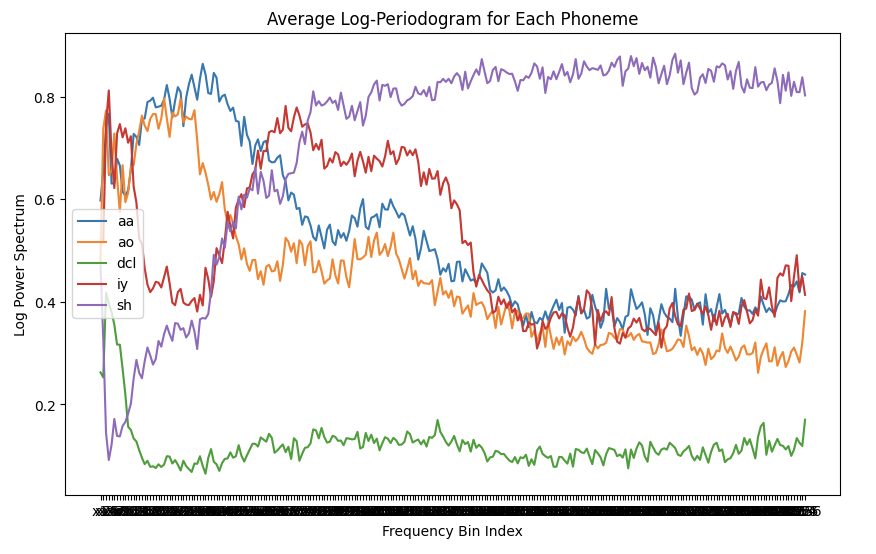
1. **Experiment Setup**: The two-model approach first trained an LDA classifier on the full dataset after polynomial feature expansion, speaker-specific scaling, and PCA for dimensionality reduction. Initial predictions were generated using this model. The instances predicted as 'aa' or 'ao' were then isolated, forming a subset for further refinement. This subset was transformed using an additional PCA process to retain more relevant phoneme-specific information. The second model, another LDA classifier, was then trained exclusively on this subset to enhance distinction between 'aa' and 'ao'. This was tested on a five-fold cross validation set. GridSearch was used to identify the best model between LogisticRegression, LDA, QDA, and SVM. The GridSearch was also used to identify the best hyperparameters and the use of PCA or LDA for feature selection.
1. **Results**: The two-model approach resulted in improved classification performance, with cross-validation accuracy increasing from 93.1% to 93.9%. The classification report showed increased precision and recall for 'aa' and 'ao', reducing their misclassification rate. This demonstrated that targeted reclassification using additional transformations successfully enhanced phoneme separability. Further refinements, such as alternative feature engineering techniques (log, sqrt, exp, change in frequency) or  different classification models for the second stage did not improve accuracy.

<font color=green><h3><b>$\zeta$. References</b></h3>
<details>
  <summary>Instructions</summary>
  <div>

1. Cite your sources to help your peers learn from these (and to avoid plagiarism).
1. HOML textbook should be cited, since we used it in this week's learning.
1. Use Google Scholar to draw [APA](https://en.wikipedia.org/wiki/American_Psychological_Association) citation format for books and publications.
1. Cite [StackOverflow](https://stackoverflow.com/), YouTube videos, package docs, open-access textbooks/publicaitons and other meaningful internet resources that you used.
1. We may reward exceptional and meaningful citations (not just a list of [SKL](https://scikit-learn.org/stable/)/[TF](https://www.tensorflow.org/) manual pages and a list of articles.) For example, if you used an idea from a publication, indicate it in TGP with a number that corresponds to its reference in References.

</div> </details>
</font>

1. Geron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow. 2nd Ed., Sebastopol, CA: O’Reilly, 2019.
1. Garofolo, J. S., Lamel, L. F., Fisher, W. M., Fiscus, J. G., Pallett, D. S., & Dahlgren, N. L. (1993). TIMIT Acoustic-Phonetic Continuous Speech Corpus. https://doi.org/https://doi.org/10.35111/17gk-bn40
1. 12.1 estimating the Spectral Density: Stat 510. PennState: Statistics Online Courses. (2024). https://online.stat.psu.edu/stat510/lesson/12/12.1


<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 59 sec


<details>
  <summary><font size=5><b>💡Starter Ideas</b></font></summary>
  <div>
  
1. Tune model hyperparameters
1. Try smarter sampling from the training set to avoid using all observations (due to time constraint) and, instead, develop more features
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA: look for feature augmentations that result in linear decision boundaries between pairs of classes.
1. Try encoding and/or incorporating speaker ID. For example, you could scale/transform each speaker's observations separately.
1. Carefully read the example in [ESL textbook, p.149](https://hastie.su.domains/ElemStatLearn/printings/ESLII_print12.pdf#page=168), check seminar Colab and lecture slides
1. Check difference in distribution between test and train data. You might consider [group k-fold](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) for testing locally or your model will memorize user-phoneme releation, instead of phoneme attributes and class.
1. Learn the domain to develop better features. See ["Penalized discriminant analysis"](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C48&q=Penalized+Discriminant+Analysis&btnG=)
1. Look for training outliers that can affect your model's test performance.
  1. Essentially, you need to find and exclude training [influential points](https://en.wikipedia.org/wiki/Influential_observation), but training outliers might be influential
  1. Brute force with [LOOCV](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) is slow, but robust. You might find methods to find each training point's contribution to the prediction and remove rare extreme contributors (since they may not be in the test set)
  1. You can find outliers; then evaluate their effect on model's performance
    1. You can evaluate 1D and 2D histograms to find outliers and
    1. You can cluster observations and find outliers that don't fit the clusters (DBSCAN may be helpful)
    1. You can compress high dimensional space to 1D (with PCA, tSNE, UMAP) and then find outliers with a histogram
 1. Additional info:
    1. Harmonics: [wiki](https://en.wikipedia.org/wiki/Harmonic), [sinusoidal regression](https://www.youtube.com/results?search_query=regression+sinusoidal)
    1. Discrete Fourier Transofrm (DFT): [wiki](https://en.wikipedia.org/wiki/Discrete_Fourier_transform), [Steve Brunton @UW](https://www.youtube.com/watch?v=nl9TZanwbBk), [YouTube search](https://www.youtube.com/results?search_query=Discrete+Fourier+transform)
    1. Spectral density estimation [(wiki)](https://en.wikipedia.org/wiki/Spectral_density_estimation), [YouTube search](https://www.youtube.com/results?search_query=spectral+density+estimation)

</div> </details>